# Zelfde experiment als eerder, alleen ditmaal met mfcc


In [29]:
%reload_ext autoreload
%autoreload 2
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io.wavfile as wv
import scipy.signal as sig
import wave

from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense

from contextlib import redirect_stdout

from util import util
from util import WavFileParts
from util.logUtil import LOG, LOG_HEADER
from util.confusionMatrix import ConfusionMatrix

from python_speech_features import mfcc

### globale settings

In [2]:
classes = ['music', 'voice', 'environment']

macDir = '/Volumes/SAA_DATA/datasets/'
winDir = 'E:/SAA_DATA/'
osDir = winDir
recordingDir = osDir + '/localizationRecordings'

if osDir == winDir:
    storageFolder = 'E:/SAA_DATA/storedData/'
else:
    storageFolder = '/Users/etto/Desktop/storedData/'

baseSrcDir = osDir + 'localizationFiles/20171025AllExtractionsMic4'
orgWavDirs1 = ['G428_0.0_1.4',
              'G527_0.5_1.4',
              'Studio_2.0_4.2'
              ]

orgWavDirs2 = ['G428_2.1_2.4',
              'G527_1.2_5.8',
              'Studio_3.0_2.0'
              ]

orgsG428 = ['G428_0.0_1.4','G428_2.1_2.4']
orgsG527 = ['G527_0.5_1.4','G527_1.2_5.8']
orgsStudio = ['Studio_2.0_4.2','Studio_3.0_2.0']

chunksBaseDir = 'chunks'
rooms = ['Studio', 'G428', 'G527']

### utility functies

In [35]:
def readSoundChunksDynamic(moduleString):
    chunks = importlib.import_module(moduleString).soundChunks
    wfPts = []
    for jsonString in chunks:
        wfPts.append(WavFileParts.WavFilePartFromJson(jsonString))
    return wfPts

def timeFunction(func):
    """
    Aanroep: bijv. fpc = timeFunction(lambda: getFilesPerCategory(srcDir))
    """
    startTime = datetime.now()
    print('Start: ' + startTime.strftime('%H:%M:%S') + '\n=================')

    res = func()
    
    endTime = datetime.now()
    print('\n=================\nEnd: ' + endTime.strftime('%H:%M:%S'))
    print('Time taken: '),
    print(endTime - startTime)
    print()
    
    return res
    
def storeTestData(allMfccs, allClasses, storageName, keyName):
    filename = storageFolder + storageName + '_MFCC.hd5'
    df = pd.DataFrame(allMfccs)
    df.to_hdf(path_or_buf=filename, key='mfccs_' + keyName)

    df = pd.DataFrame(allClasses)
    df.to_hdf(path_or_buf=filename, key='classes_' + keyName)

def retrieveTestData(storageName, keyName):
    filename = storageFolder + storageName + '_MFCC.hd5'
    allMfccsDf = pd.read_hdf(path_or_buf=filename, key='mfccs_' + keyName)
    classesDf = pd.read_hdf(path_or_buf=filename, key='classes_' + keyName)
    return allMfccsDf.values, classesDf.values
    

### functies tbv trainen

In [4]:
# Maakt een dictionary aan; per categorie alle files (volledig pad) uit de srcDir
# srcDir is een van de orgWavDirs, bijvoorbeeld
#    localizationFiles/20171025AllExtractionsMic4/G428_0.0_1.4
def getFilesPerCategory(srcDir):
    filesPerCategory = {}
    for catDirLong in glob.glob(srcDir + '/*'):
        catDir = catDirLong.replace('\\', '/')
        catDir = catDir.replace(srcDir + '/', '')

        filesPerCategory[catDir] = []
        for filename in glob.glob(catDirLong + '/*'):
            filename = filename.replace('\\','/')
            filesPerCategory[catDir].append(filename)
    return filesPerCategory

def getFilesPerCatFromMultipleDirs(srcDirs, srcDirsBase=''):
    filesPerCat = {}
    for dirName in srcDirs:
        srcDir = srcDirsBase + '/' + dirName
        fpcNw = getFilesPerCategory(srcDir)
        if not filesPerCat:
            filesPerCat = fpcNw
        else:
            for key in filesPerCat:
                filesPerCat[key] += fpcNw[key]
    return filesPerCat
        

In [5]:
# Maakt een dictionary aan; per categorie de spectrogrammen
def getMFCCsFromFilesPerCategory(filesPerCategory):
    mfccs = {}
    nfft = 1024
    for clz in classes:
        mfccs[clz] = []
        for filename in filesPerCategory[clz]:
            fs, signal = wv.read(filename)
            winlen = nfft/fs 
            mfcc_feat = mfcc(signal, samplerate=fs, winlen=winlen, winstep=winlen, nfft=nfft)
            mfccs[clz].append(mfcc_feat)
    return mfccs

In [6]:
def getClassLengths(mfccsPerCat):
    clzLengths = {}
    for clz in classes:
        clzLengths[clz] = sum([np.shape(lst)[0] for lst in mfccsPerCat[clz]])
    return clzLengths

In [7]:
# verwacht invoer van getMFCCsFromFilesPerCategory
# levert traindata op (X_train en Y_train)
def createTrainDataFromMFCCs(mfccsPerCat, clzLengths):
    X_train = np.concatenate(mfccsPerCat[classes[0]], axis=0)
    for i in range(1, len(classes)):
        nwMFCCs = np.concatenate(mfccsPerCat[classes[i]], axis=0)
        X_train = np.concatenate((X_train,nwMFCCs), axis=0)
    
    # one-hot encoding voor Y_train
    nrFiles = clzLengths[classes[0]]
    Y_train = np.array((np.ones(nrFiles),np.zeros(nrFiles), np.zeros(nrFiles))).T

    nrFiles = clzLengths[classes[1]]
    Y_train_nw = np.array((np.zeros(nrFiles), np.ones(nrFiles), np.zeros(nrFiles))).T
    Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)

    nrFiles = clzLengths[classes[2]]
    Y_train_nw = np.array((np.zeros(nrFiles), np.zeros(nrFiles), np.ones(nrFiles))).T
    Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)
    
    return X_train, Y_train

### deep learning model

In [8]:
def create_model(layersizes):
    # create model
    nr_inputs = 13
    model = Sequential()
    model.add(Dense(layersizes[0], input_dim=nr_inputs, activation='relu'))
    for lsize in layersizes[1:]:
        model.add(Dense(lsize, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
def getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs):
    modelFilename = modelFilePath + baseModelFilename
    for lsize in layers:
        modelFilename = '{}_{}'.format(modelFilename, lsize)
    modelFilename += 'ep{}'.format(nrEpochs)
    modelFilename += '.hd5'
    return modelFilename

In [10]:
def getModelName(baseModelFilename, layers, nrEpochs):
    modelFilename = baseModelFilename
    for lsize in layers:
        modelFilename = '{}_{}'.format(modelFilename, lsize)
    modelFilename += 'ep{}'.format(nrEpochs)
    return modelFilename

In [11]:
def train_model(X_train, Y_train, layers, nrEpochs, modelFilePath, baseModelFilename, batch_size=None):
    soundModel = create_model(layers)
    history = timeFunction(lambda: soundModel.fit(X_train,Y_train, epochs=nrEpochs, shuffle=True, verbose=1, batch_size=batch_size))
    soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))
    plt.plot(history.history['loss'])
    plt.show()

In [12]:
def train_and_evaluate_model(X_train, Y_train, realTrainClasses, layers, nrEpochs, modelFilePath, baseModelFilename, batch_size=None):
    soundModel = create_model(layers)
    history = timeFunction(lambda: soundModel.fit(X_train,Y_train, epochs=nrEpochs, shuffle=True, verbose=1, batch_size=batch_size))
    soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))
    plt.plot(history.history['loss'])
    plt.show()
    evaluate_model(X_train, realTrainClasses,layers, nrEpochs, modelFilePath, baseModelFilename)

In [13]:
def evaluate_model(X_test, realClasses, layers, nrEpochs, modelFilePath, baseModelFilename):
    soundModel = load_model(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))

    # predicted classes
    predictions = soundModel.predict(X_test)
    predClasses = predictions.argmax(axis=1)

    matrix = ConfusionMatrix(classes)
    for vals in zip(realClasses, predClasses):
        matrix.add(int(vals[0]), int(vals[1]), 1)
    LOG(matrix.toString(),True)
    LOG('', True)
    LOG(matrix.toF1String(), True)
    return matrix

In [14]:
def train_and_evaluate_per_epoch(X_train, Y_train, realClasses, layers, nrEpochs, modelFilePath, baseModelFilename, batch_size=None):
    soundModel = create_model(layers)
    for epNr in range(1, nrEpochs+1):
        LOG('\n*****************\n* Epoch nr {}\n*****************\n'.format(epNr), True)
        soundModel.fit(X_train,Y_train, epochs=1, shuffle=True, verbose=1, batch_size=batch_size)
        soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, epNr))
        evaluate_model(X_train, realClasses, layers, epNr, modelFilePath, baseModelFilename)

### functies tbv testen

In [15]:
def createAndStoreTestData(wavFileParts, baseDir, fileDate, micNr, storeFilename, keyName):
    nfft = 1024
    allMfccs = np.array([])
    allClasses = np.array([])

    for wfPt in wavFileParts: #type: WavFilePart
        if not 'Gunshot' in wfPt.getSoundType():
            filename = baseDir + '/{:d}_{:d}_mono{:d}.wav'.format(fileDate, wfPt.fileNr, micNr)
            fs, signal = wv.read(filename)
            winlen = nfft / fs
            classNr = classes.index(wfPt.getSoundType().lower())
            for soundChunk in wfPt.getSoundChunks(micNr):
                startFrame = int(soundChunk[0] * fs)
                endFrame = int(soundChunk[1] * fs)

                sigChunk = signal[startFrame: endFrame]
                mfcc_feat = mfcc(sigChunk, samplerate=fs, winlen=winlen, winstep=winlen, nfft=nfft)
                if len(allMfccs) == 0:
                    allMfccs = mfcc_feat
                else:
                    allMfccs = np.append(allMfccs, mfcc_feat, axis=0)
                allClasses = np.append(allClasses, classNr * np.ones(len(mfcc_feat)))
                
                # print('sigchunk: \t{}\tmfccs: \t{}\tallMfccs: \t{}'.format(len(sigChunk), np.shape(mfcc_feat), np.shape(allMfccs)))
    storeTestData(allMfccs, allClasses, storeFilename, keyName)


In [16]:
def getTrainDataFromFolders(orgWavDirs):
    fpc = getFilesPerCatFromMultipleDirs(orgWavDirs, baseSrcDir)
    mfccs = getMFCCsFromFilesPerCategory(fpc)
    clzLengths = getClassLengths(mfccs)
    X_train, Y_train = createTrainDataFromMFCCs(mfccs, clzLengths)
    # real train classes
    realTrainClasses = np.concatenate((np.zeros(clzLengths[classes[0]]), 
                                  np.ones(clzLengths[classes[1]]), 
                                  2*np.ones(clzLengths[classes[2]])))
    return X_train, Y_train, realTrainClasses


In [17]:
def testModellen(modelFilePath, layerss, micNr, testFileNames, showOverall=True):

    # test data
    keyname = 'mic{}'.format(micNr)

    for layers in layerss:
        for nrEpochs in nrsEpochs:
            overallMatrix = ConfusionMatrix(classes)
            for testFileName in testFileNames:
                testSpecs, testClasses = retrieveTestData(testFileName, keyname)

                LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                           + '\n# ' + keyname
                           + '\n# ' + testFileName,
                           True)
                matrix = evaluate_model(testSpecs, testClasses, layers, nrEpochs, modelFilePath, baseModelFilename)
                overallMatrix.addMatrix(matrix.normalizedCopy())
            
            if showOverall:
                overallMatrix = overallMatrix.normalizedCopy()
                LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                           + '\n# ' + keyname
                           + '\n# ' + 'testData_Overall',
                           True)
                LOG(overallMatrix.toString(),True)
                LOG('', True)
                LOG(overallMatrix.toF1String(), True)

In [18]:
def testModel(modelFilePath, layers, micNr, testFileNames, nrEpochs, showOverall=True):

    # test data
    keyname = 'mic{}'.format(micNr)

    overallMatrix = ConfusionMatrix(classes)
    for testFileName in testFileNames:
        testSpecs, testClasses = retrieveTestData(testFileName, keyname)

        LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                   + '\n# ' + keyname
                   + '\n# ' + testFileName,
                   True)
        matrix = evaluate_model(testSpecs, testClasses, layers, nrEpochs, modelFilePath, baseModelFilename)
        overallMatrix.addMatrix(matrix.normalizedCopy())

    if showOverall:
        overallMatrix = overallMatrix.normalizedCopy()
        LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                   + '\n# ' + keyname
                   + '\n# ' + 'testData_Overall',
                   True)
        LOG(overallMatrix.toString(),True)
        LOG('', True)
        LOG(overallMatrix.toF1String(), True)

### trainen van model obv: alles G428, G527 en Studio

In [28]:
# Train voor alle lagen
baseModelFilename = '20190104_MFCC'
modelFilePath = storageFolder
logPrefix = 'Alle orgs'
orgWavDirs = orgsG428 + orgsG527 + orgsStudio

In [20]:
X_train, Y_train, realTrainClasses = getTrainDataFromFolders(orgWavDirs)

In [21]:
np.shape(X_train)

(277114, 13)

In [22]:
# Maak test data
LOG_HEADER('maak mfccs voor testdata G428', True)
wvPts = readSoundChunksDynamic('chunks.G428.soundChunks')
baseDir = recordingDir + '/20170221'
fileDate = 170221
filename = 'testData_G428'
for micNr in [1,2,3,4]:
    keyname = 'mic{}'.format(micNr)
    createAndStoreTestData(wvPts, baseDir, fileDate, micNr, filename, keyname)

LOG('Klaar: mfccs voor testdata G428', True)

####################################
#
# maak mfccs voor testdata G428
#
####################################



C:\Users\Etto\Anaconda2\envs\py36DL\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Klaar: mfccs voor testdata G428


In [25]:
# Maak test data
LOG_HEADER('maak mfccs voor testdata G527}', True)
wvPts = readSoundChunksDynamic('chunks.G527.soundChunks')
baseDir = recordingDir + '/20170221'
fileDate = 170221
filename = 'testData_G527'
for micNr in [1,2,3,4]:
    keyname = 'mic{}'.format(micNr)
    createAndStoreTestData(wvPts, baseDir, fileDate, micNr, filename, keyname)

LOG('Klaar: mfccs voor testdata G527', True)

####################################
#
# maak mfccs voor testdata G527}
#
####################################



C:\Users\Etto\Anaconda2\envs\py36DL\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Klaar: mfccs voor testdata G527


In [24]:
LOG_HEADER('maak mfccs voor testdata Studio', True)
wvPts = readSoundChunksDynamic('chunks.Studio.soundChunks')
baseDir = recordingDir + '/20171011'
fileDate = 170816
filename = 'testData_Studio'
for micNr in [1,2,3,4]:
    keyname = 'mic{}'.format(micNr)
    createAndStoreTestData(wvPts, baseDir, fileDate, micNr, filename, keyname)

LOG('Klaar: mfccs voor testdata Studio', True)

####################################
#
# maak mfccs voor testdata Studio
#
####################################



C:\Users\Etto\Anaconda2\envs\py36DL\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Klaar: mfccs voor testdata Studio


In [32]:
layersList = [[13,5],[10,6,4],[50,20,10,3],[5],[6,5,5],[13,12,11,10,9,8,7,6,5,4,3]]
nrEpochs = 5
nrsEpochs = range(1, nrEpochs + 1)
#nrsEpochs = [nrEpochs]
bSize = 128

In [33]:
for layers in layersList:
    LOG_HEADER(logPrefix + ', lagen: {}'.format(str(layers)), True)
    train_and_evaluate_per_epoch(X_train, Y_train, realTrainClasses, 
                                 layers, nrEpochs, modelFilePath, baseModelFilename,
                                batch_size=bSize)

####################################
#
# Alle orgs, lagen: [13, 5]
#
####################################


*****************
* Epoch nr 1
*****************

Epoch 1/1
277114/277114 [==============================] - 9s 34us/step - loss: 0.4181 - acc: 0.8619
                   m       v       e |  sens   acc
music          87769    3291     589 |  0.96  0.97
voice           2942   86673    2075 |  0.95  0.96
environment      717    1679   91379 |  0.97  0.98
--------------------------------------
prec            0.96    0.95    0.97

F1 overall: 0.96
F1 music: 0.96
F1 voice: 0.95
F1 environment: 0.97


*****************
* Epoch nr 2
*****************

Epoch 1/1
277114/277114 [==============================] - 8s 28us/step - loss: 0.1009 - acc: 0.9634
                   m       v       e |  sens   acc
music          89021    2270     358 |  0.97  0.98
voice           3143   86686    1861 |  0.95  0.97
environment      505    1321   91949 |  0.98  0.99
-----------------------------------

277114/277114 [==============================] - 7s 25us/step - loss: 0.1547 - acc: 0.9471
                   m       v       e |  sens   acc
music          86919    3756     974 |  0.95  0.97
voice           3163   86033    2494 |  0.94  0.96
environment     1099    2340   90336 |  0.96  0.98
--------------------------------------
prec            0.95    0.93    0.96

F1 overall: 0.95
F1 music: 0.95
F1 voice: 0.94
F1 environment: 0.96


*****************
* Epoch nr 3
*****************

Epoch 1/1
277114/277114 [==============================] - 7s 25us/step - loss: 0.1386 - acc: 0.9500
                   m       v       e |  sens   acc
music          87442    3258     949 |  0.95  0.97
voice           3440   85253    2997 |  0.93  0.96
environment     1113    1685   90977 |  0.97  0.98
--------------------------------------
prec            0.95    0.95    0.96

F1 overall: 0.95
F1 music: 0.95
F1 voice: 0.94
F1 environment: 0.96


*****************
* Epoch nr 4
*****************

Epoch 

In [36]:
fileName='plots/20190104_MFCC.txt'
with open(fileName, 'w') as f:
    with redirect_stdout(f):       
        testModellen(modelFilePath=storageFolder, 
                     layerss=layersList, 
                     micNr=4, 
                     testFileNames=['testData_G428', 'testData_G527', 'testData_Studio'], 
                     showOverall=True)               

In [37]:
from parseExperimentResults import parseRedoExperiment

creating plots in plots/20190104_MFCC/


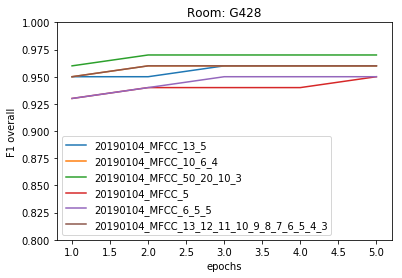

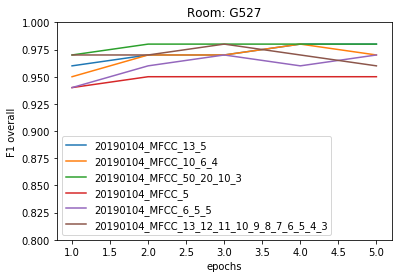

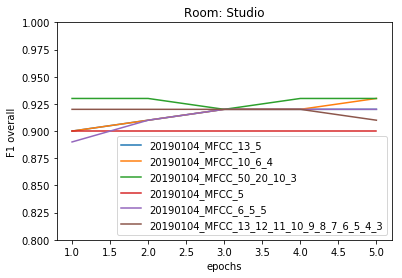

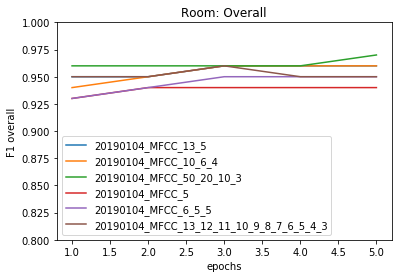

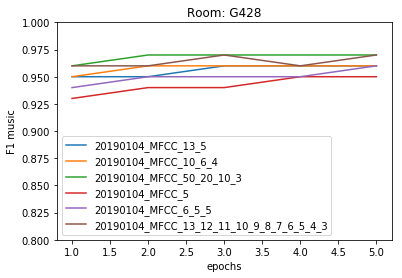

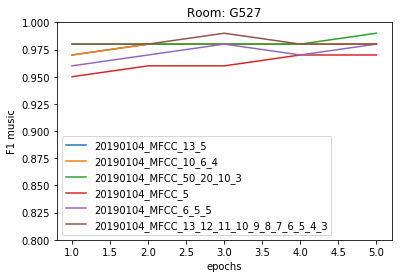

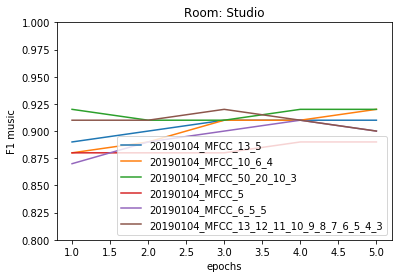

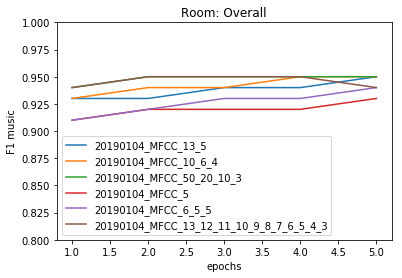

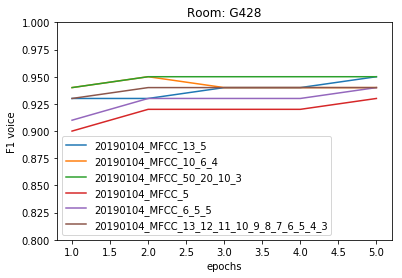

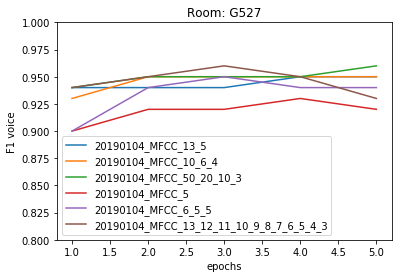

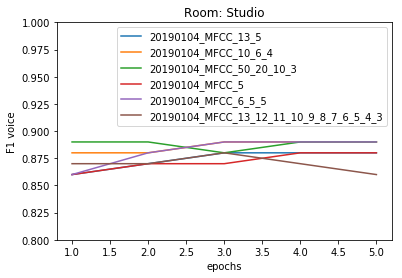

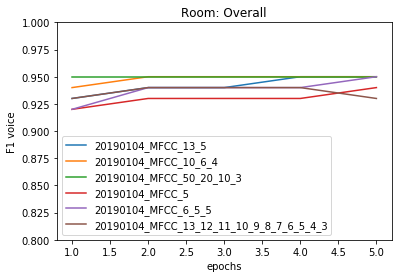

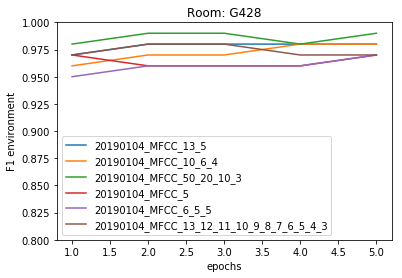

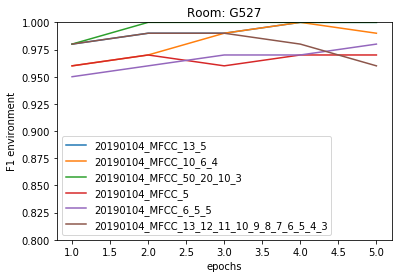

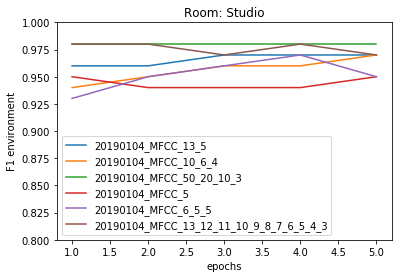

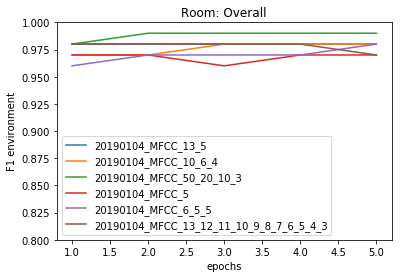

In [38]:
experimentId=baseModelFilename
filePattern=baseModelFilename
parseRedoExperiment(experimentId, filePattern)